# Decision Trees and Random Forests

Based on Chapter 5 from *Python for Data Science Handbook*, by Jake VanderPlas.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set()
from scipy import stats

#import warnings
#warnings.filterwarnings("ignore")

### Motivating Random Forests: Decision Trees

Random forests are an example of an *ensemble learner* built on decision trees.
For this reason we'll start by discussing decision trees themselves.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification.
For example, if you wanted to build a decision tree to classify an animal you come across while on a hike, you might construct the one shown here:

<center>
    <img src="images/05.08-decision-tree.png" width="700" />
</center>

The binary splitting makes this extremely efficient: in a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes. The trick, of course, comes in deciding which questions to ask at each step. In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features. Let's now look at an example of this.



### Creating a decision tree

Consider the following two-dimensional data, which has one of four class labels:

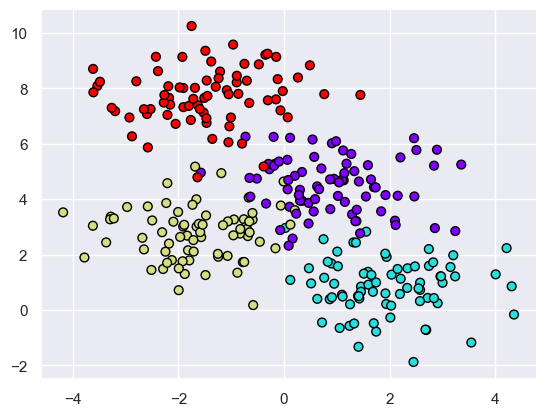

In [2]:
from sklearn.datasets import make_blobs

# Generate synthetic data with 300 samples and 4 centers (clusters)
X, y = make_blobs(n_samples=300,    # Number of samples
                  centers=4,        # Number of clusters (centers)
                  random_state=0,   # Seed for reproducibility
                  cluster_std=1.0)  # Standard deviation of clusters

# Plot the generated data
plt.scatter(X[:, 0], X[:, 1],  # Plot points with x and y coordinates
            c=y,               # Color points by cluster label
            s=40,              # Size of the points
            cmap='rainbow',    # Colormap for coloring points
            edgecolor='black') # Border color for the data point markers
            
plt.show()  # Display the plot

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it. This figure presents a visualization of the first four levels of a decision tree classifier for this data:

<center>
    <img src="images/05.08-decision-tree-levels.png" width="1000" />
</center>

Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch.
Except for nodes that contain all of one color, at each level *every* region is again split along one of the two features.

This process of fitting a decision tree to our data can be done in Scikit-Learn with the ``DecisionTreeClassifier`` estimator:

In [3]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train a Decision Tree classifier on the dataset
tree = DecisionTreeClassifier()  # Create a Decision Tree classifier instance
tree.fit(X, y)                   # Fit the model to the data (X: features, y: target labels)

DecisionTreeClassifier()

Let's write a quick utility function to help us visualize the output of the classifier:

In [4]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    """Visualize the decision boundary of a classifier along with the training points.
    
    Parameters:
    - model: The classifier model to be visualized.
    - X: Feature data (2D array) used for training.
    - y: Target labels corresponding to the features.
    - ax: Matplotlib axis object to plot on. If None, the current axis is used.
    - cmap: Colormap to use for plotting.
    """
    
    # Use the provided axis or create a new one
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)  # Scatter plot of the data points
    ax.axis('tight')  # Set axis limits to fit the data
    ax.axis('off')    # Hide the axis
    xlim = ax.get_xlim()  # Get the x-axis limits
    ylim = ax.get_ylim()  # Get the y-axis limits
    
    # Fit the model to the data
    model.fit(X, y)
    
    # Create a grid of points to evaluate the decision boundary
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)  # Predict class labels for each point in the grid

    # Create a color plot to show the decision boundary
    n_classes = len(np.unique(y))  # Number of unique classes
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap,  # Plot decision boundaries with colors
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)  # Set the limits for the x and y axes

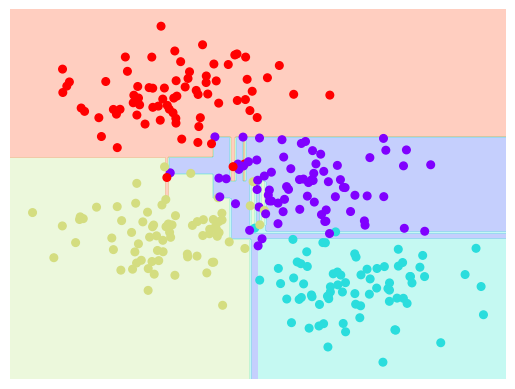

In [5]:
# Visualize the decision boundary of the DecisionTreeClassifier
visualize_classifier(DecisionTreeClassifier(), X, y)

### Decision trees and over-fitting

Such over-fitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from.
Another way to see this over-fitting is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data:

<center>
    <img src="images/05.08-decision-tree-overfitting.png" width="1000" />
</center>

It is clear that in some places, the two trees produce consistent results (e.g., in the four corners), while in other places, the two trees give very different classifications (e.g., in the regions between any two clusters).
The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from *both* of these trees, we might come up with a better result!

## Ensembles of Estimators: Random Forests

This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called *bagging*.
Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.
An ensemble of randomized decision trees is known as a *random forest*.

This type of bagging classification can be done manually using Scikit-Learn's ``BaggingClassifier`` meta-estimator, as shown here:

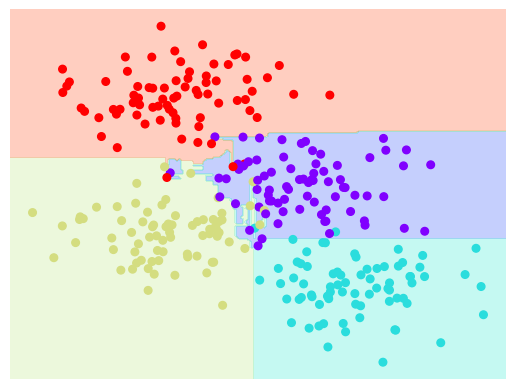

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Initialize a DecisionTreeClassifier
tree = DecisionTreeClassifier()

# Initialize a BaggingClassifier using the DecisionTreeClassifier as the base estimator
bag = BaggingClassifier(tree,             # Base estimator (tree)
                        n_estimators=100, # Use 100 base estimators (trees)
                        max_samples=0.8,  # Each base estimator is trained on 80% of the training data
                        random_state=1)   # Set the random seed for reproducibility

# Fit the BaggingClassifier on the training data
bag.fit(X, y)

# Visualize the decision boundary of the trained BaggingClassifier
visualize_classifier(bag, X, y)

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points.
In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.
For example, when determining which feature to split on, the randomized tree might select from among the top several features.
You can read more technical details about these randomization strategies in the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) and references within.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the ``RandomForestClassifier`` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:

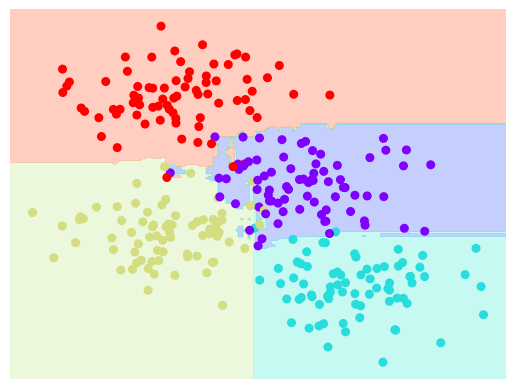

In [7]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a RandomForestClassifier with 100 trees
model = RandomForestClassifier(n_estimators=100,  # Number of trees in the forest
                               random_state=0)    # Set the random seed for reproducibility

# Visualize the decision boundary of the trained RandomForestClassifier
visualize_classifier(model, X, y);                # X and y are the feature data and target labels

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

## Random Forest Regression

In the previous section we considered random forests within the context of classification.
Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is the ``RandomForestRegressor``, and the syntax is very similar to what we saw earlier.

Consider the following data, drawn from the combination of a fast and slow oscillation:

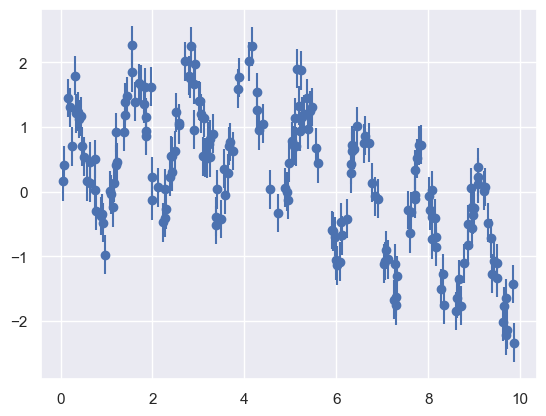

In [8]:
# Set a random seed for reproducibility
rng = np.random.RandomState(42)

# Generate 200 random numbers in the range [0, 10)
x = 10 * rng.rand(200)

# Define a model function that combines two sine waves and adds noise
def model(x, sigma=0.3):
    
    fast_oscillation = np.sin(5 * x)     # Fast oscillation component
    slow_oscillation = np.sin(0.5 * x)   # Slow oscillation component
    noise = sigma * rng.randn(len(x))    # Additive noise component

    return slow_oscillation + fast_oscillation + noise   # Return the combined signal with noise

# Generate the y values using the model function
y = model(x)

# Plot the data with error bars
plt.errorbar(x, y, 0.3, fmt='o');  # 0.3 represents the error bar length, 'o' specifies the marker style

Using the random forest regressor, we can find the best fit curve as follows:

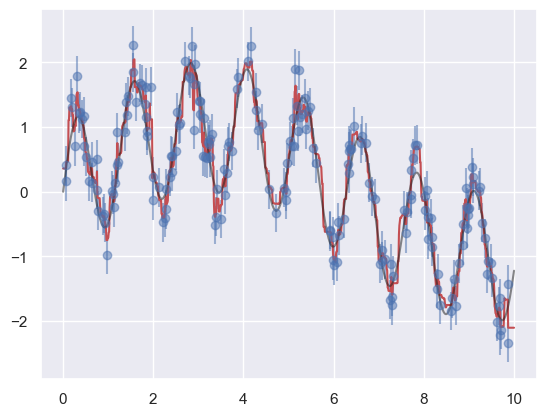

In [9]:
from sklearn.ensemble import RandomForestRegressor

# Initialize a RandomForestRegressor with 200 trees
forest = RandomForestRegressor(200)

# Fit the RandomForest model to the training data (x, y)
forest.fit(x[:, None], y)  # x[:, None] reshapes x to a 2D array, which is required by the model

# Generate an array of 1000 equally spaced points between 0 and 10
xfit = np.linspace(0, 10, 1000)

# Use the fitted RandomForest model to predict y values for the xfit points
yfit = forest.predict(xfit[:, None])

# Generate the true y values (without noise) for the xfit points
ytrue = model(xfit, sigma=0)

# Plot the original data points with error bars
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)  # alpha=0.5 makes the points semi-transparent

# Plot the predictions from the RandomForest model
plt.plot(xfit, yfit, '-r')  # '-r' specifies a red line

# Plot the true model (without noise) for comparison
plt.plot(xfit, ytrue, '-k', alpha=0.5);  # '-k' specifies a black line, alpha=0.5 makes it semi-transparent

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve. As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model!

## Example: Random Forest for Classifying Digits

Earlier we took a quick look at the hand-written digits data. Let's use that again here to see how the random forest classifier can be used in this context.

In [10]:
from sklearn.datasets import load_digits

# Load the digits dataset from sklearn's built-in datasets
digits = load_digits()

# Display the keys of the dataset dictionary to understand its structure
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

To remind us what we're looking at, we'll visualize the first few data points:

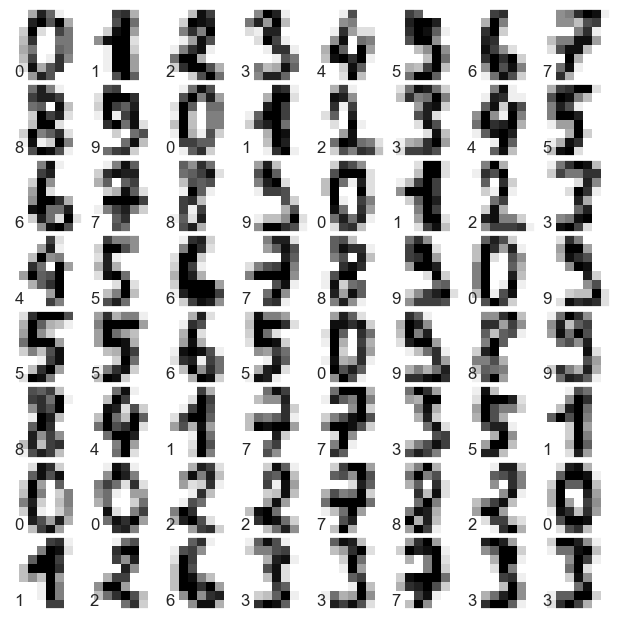

In [11]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # Create a figure with a size of 6x6 inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)  # Adjust subplot spacing

# plot the digits: each image is 8x8 pixels
for i in range(64):  
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])                   # Add a subplot with no x or y ticks
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')  # Display the image in binary colormap

    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))  # Add a text label with the target value at the bottom-left of the image

We can quickly classify the digits using a random forest as follows:

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split the dataset into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    digits.data,       # Feature data (flattened images)
    digits.target,     # Target labels (digit values)
    random_state=0     # Seed for reproducibility
)

# Initialize the RandomForestClassifier with 1000 estimators
model = RandomForestClassifier(n_estimators=1000)

# Fit the model on the training data
model.fit(Xtrain, ytrain)

# Predict the target labels for the test data
ypred = model.predict(Xtest)

We can take a look at the classification report for this classifier:

In [13]:
from sklearn import metrics

# Generate and print a classification report
print(metrics.classification_report(ypred,  # Predicted labels from the model
                                    ytest)) # True labels from the test set

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       1.00      0.96      0.98        45
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



And for good measure, plot the confusion matrix:

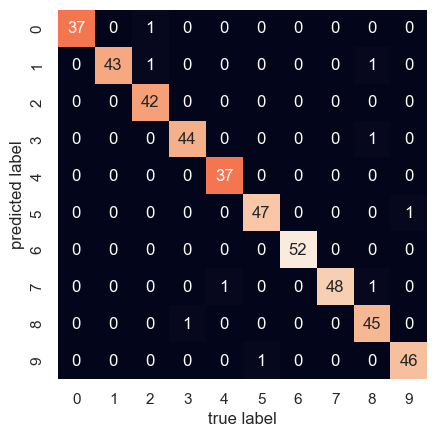

In [14]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix to evaluate the accuracy of the classification
mat = confusion_matrix(ytest,  # True labels from the test set
                       ypred)  # Predicted labels from the model

# Plot the confusion matrix as a heatmap
sns.heatmap(mat.T,             # Transpose of the confusion matrix for better visualization
            square=True,       # Set the plot to be square
            annot=True,        # Annotate cells with the numeric values of the confusion matrix
            fmt='d',           # Format the annotations as integers
            cbar=False)        # Do not display the color bar

# Label the axes of the heatmap
plt.xlabel('true label')       # Label for the x-axis representing the true labels
plt.ylabel('predicted label'); # Label for the y-axis representing the predicted labels

We find that a simple, untuned random forest results in a very accurate classification of the digits data.
